In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


This note is for 'advanced-dls-spring-2021' Kaggle competition.
There are two tables, train and test. Both of them contain independent variables (X) whereas train also contains independent variable (y)

For evaluating ROC-AUC metrics is used

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Import data

In [4]:
test_data = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')
train_data = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
train_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


As far as table contains numerical and categorical variables, I created lists of them for further separate processing

In [5]:
# numerical columns
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# categorical columns
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
y_col = 'Churn'

If we'll look at variables info, we'd mention that TotalSpent variable should be numerical but named as 'object'. During further processing without changes I noted that this variable contains not only numbers but also empty strings. Let's find them, replace by NaN, then calculate TotalSpent median and finally with fillna replaced by median value.

In [6]:
print(train_data.info(), test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
train_data = train_data.replace(' ', np.nan)
test_data = test_data.replace(' ', np.nan)

In [8]:
print('Train:\n', train_data.isna().sum(), '\nTest:\n', test_data.isna().sum())

Train:
 ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64 
Test:
 ClientPeriod                0
MonthlySpending             0
TotalSpent                  2
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDevicePr

In [9]:
TotalSpent_median = train_data[train_data['TotalSpent'] != 'NaN'].TotalSpent.median()
train_data['TotalSpent'] = train_data['TotalSpent'].fillna(TotalSpent_median)
test_data['TotalSpent'] = test_data['TotalSpent'].fillna(TotalSpent_median)

Check variables types again. Now TotalSpent is float64, as it should be

In [11]:
train_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'])
test_data['TotalSpent'] = pd.to_numeric(test_data['TotalSpent'])
train_data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                  float64
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

Now I plot distribution graphs for numerical variables. Here I use violinplot, it is a mix of histogram and box plot.
I also plot countplot for categorical variables, include dependent variable 'Churn' (y), for looking at variables' meanings and their amount

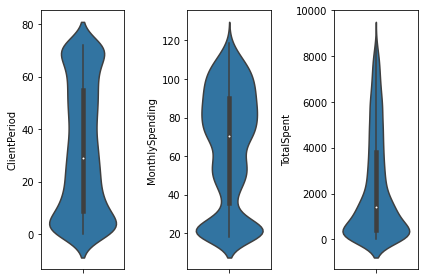

In [12]:
fig, ax = plt.subplots(ncols=3)
for i in range(len(num_cols)):
    sns.violinplot(data = train_data, y = num_cols[i], ax = ax[i])
fig.tight_layout()
plt.show()

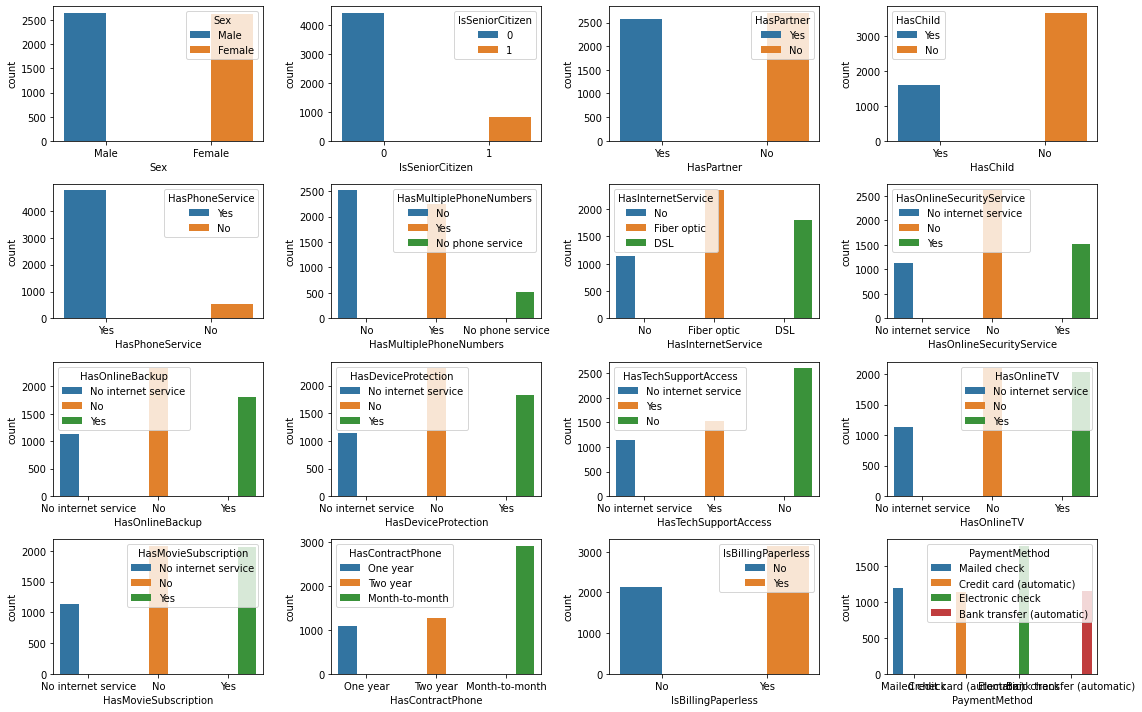

In [13]:
fig, axs = plt.subplots(nrows = 4, ncols=4)
for i in range(len(cat_cols)):
    sns.countplot(data = train_data, x = cat_cols[i], hue = cat_cols[i], ax = axs[i//4][i%4])
fig.set_figwidth(16)
fig.set_figheight(10)
fig.tight_layout()
plt.show()

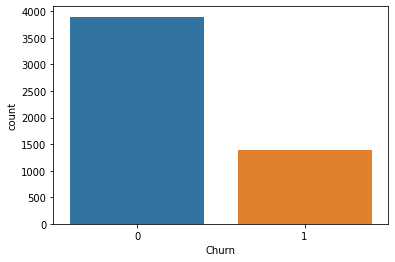

In [14]:
sns.countplot(data = train_data, x = 'Churn')
plt.show()

It can be seen at the Churn plot that amounts of 0 and 1 are not equal. However, ratio here approx 1:2.5. So, I won't do something additional (for example, SMOTE) with samples

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

Next, I build Pipeline and apply it for several modeling techniques. For the further model evaluation with ROC AUC I split train set to train_eval and test_eval

In [16]:
y_train = train_data['Churn']
X_train = train_data.drop(columns = ['Churn'])
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_train, y_train, 
                                                                        test_size = 0.2, random_state = 1) 
scaler = StandardScaler()
encoder = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder, cat_cols),
    ]
)
X_train_eval.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
246,68,108.45,7176.55,Male,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check
3847,31,79.85,2404.15,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic)
471,45,100.30,4483.95,Female,0,No,No,Yes,No,Fiber optic,Yes,Yes,No,No,Yes,Yes,One year,Yes,Electronic check
1102,5,44.80,220.45,Female,0,Yes,Yes,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check
759,1,50.75,50.75,Male,0,No,No,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check


In [17]:
clf = Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())]
)
params = {'classifier__C': [100, 10, 1, 0.1, 0.01, 0.001]}
logreg_grid = GridSearchCV(estimator = clf, param_grid = params, cv = StratifiedKFold(n_splits = 10), scoring = 'roc_auc')
logreg_grid.fit(X_train_eval, y_train_eval)
logreg_grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'classifier__C': 100}

In [19]:
logreg_predicted = logreg_grid.predict_proba(X_test_eval)[:,1]
roc_auc_score(y_test_eval, logreg_predicted)

0.8536410443298198

Thus, roc_auc for logistic regression is equal 0.854

In [24]:
clf_knn = Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]
)
params = {'classifier__n_neighbors': [10, 20, 40, 50, 60], 'classifier__leaf_size': [3, 5, 10, 15]}
smote_knn_grid = GridSearchCV(estimator = clf_knn, param_grid = params, scoring = 'roc_auc')
smote_knn_grid.fit(X_train_eval, y_train_eval)
smote_knn_pred = smote_knn_grid.predict_proba(X_test_eval)[:, 1]
print('ROC AUC:', roc_auc_score(y_test_eval, smote_knn_pred), 'Лучшие параметры: ', smote_knn_grid.best_params_)

ROC AUC: 0.8363702623906706 Лучшие параметры:  {'classifier__leaf_size': 3, 'classifier__n_neighbors': 50}


ROC AUC for KNN is equal 0.836 provided number of nearest neighbors equal 50 and leaf size equal 3

In [25]:
clf_knn = Pipeline(
    steps=[('preprocessor', preprocessor), ('pca', PCA()), ('classifier', KNeighborsClassifier())]
)
params = {'pca__n_components': np.arange(2, 7), 'classifier__n_neighbors': [20, 30, 40, 50, 60], 'classifier__leaf_size': [5, 7, 10, 15, 18]}
smote_knn_grid = GridSearchCV(estimator = clf_knn, param_grid = params, scoring = 'roc_auc')
smote_knn_grid.fit(X_train_eval, y_train_eval)
smote_knn_pred = smote_knn_grid.predict_proba(X_test_eval)[:, 1]
print('ROC AUC:', roc_auc_score(y_test_eval, smote_knn_pred), 'Лучшие параметры: ', smote_knn_grid.best_params_)

ROC AUC: 0.8413695148389027 Лучшие параметры:  {'classifier__leaf_size': 15, 'classifier__n_neighbors': 60, 'pca__n_components': 4}


I tried to add PCA in processing data.  ROC AUC for KNN raised to 0.841 provided 4 PCA components, 60 nearest neighbours and leaf size 15. For further PCA models I leave number of PCA components = 4, because this number was optimal

In [27]:
clf = Pipeline(
    steps=[('preprocessor', preprocessor), ('pca', PCA(n_components = 4)), ('classifier', RandomForestClassifier(n_estimators = 200))]
)
params = {'classifier__max_depth': [4, 5, 6, 8],
          'classifier__min_samples_leaf': [8, 9, 10, 15],
          'classifier__min_samples_split': [10, 14, 15, 16, 17, 20]
}
randforest_grid = GridSearchCV(estimator = clf, param_grid = params, scoring = 'roc_auc')
randforest_grid.fit(X_train_eval, y_train_eval)
randforest_grid.best_params_

{'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 15,
 'classifier__min_samples_split': 20}

In [28]:
randforest_predicted = randforest_grid.predict_proba(X_test_eval)[:, 1]
roc_auc_score(y_test_eval, randforest_predicted)

0.8436892614188533

ROC AUC Random Forest is equal 0.843 provided max depth 6, min samples leaf 15, min samples split 20

In [31]:
clf_ada = Pipeline(
    steps=[('preprocessor', preprocessor), ('pca', PCA(n_components = 4)), ('classifier', AdaBoostClassifier(random_state = 1))]
)
params = {'classifier__n_estimators': [20, 25, 30, 40, 50]}
smote_ada_grid = GridSearchCV(estimator = clf_ada, param_grid = params, scoring = 'roc_auc')
smote_ada_grid.fit(X_train_eval, y_train_eval)
smote_ada_pred = smote_knn_grid.predict_proba(X_test_eval)[:, 1]
print('ROC AUC:', roc_auc_score(y_test_eval, smote_ada_pred), 'Лучшие параметры: ', smote_ada_grid.best_params_)

ROC AUC: 0.8413695148389027 Лучшие параметры:  {'classifier__n_estimators': 30}


ROC AUC AdaBoostClassifier = 0,841 provided 30 estimators

In [32]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(depth = 8, learning_rate = 0.2, iterations = 40)
clf.fit(X_train_eval, y_train_eval, cat_features=cat_cols)
catboost_predict = clf.predict_proba(X_test_eval)[:, 1]
print('ROC AUC:', roc_auc_score(y_test_eval, catboost_predict))

0:	learn: 0.6247248	total: 66.9ms	remaining: 2.61s
1:	learn: 0.5824500	total: 76ms	remaining: 1.44s
2:	learn: 0.5482365	total: 81.2ms	remaining: 1s
3:	learn: 0.5236332	total: 85.1ms	remaining: 766ms
4:	learn: 0.4999955	total: 88.7ms	remaining: 621ms
5:	learn: 0.4806954	total: 95.8ms	remaining: 543ms
6:	learn: 0.4663386	total: 103ms	remaining: 486ms
7:	learn: 0.4573420	total: 105ms	remaining: 419ms
8:	learn: 0.4483445	total: 111ms	remaining: 384ms
9:	learn: 0.4399334	total: 114ms	remaining: 343ms
10:	learn: 0.4329668	total: 119ms	remaining: 314ms
11:	learn: 0.4268185	total: 127ms	remaining: 296ms
12:	learn: 0.4219772	total: 134ms	remaining: 279ms
13:	learn: 0.4180218	total: 140ms	remaining: 260ms
14:	learn: 0.4141471	total: 147ms	remaining: 245ms
15:	learn: 0.4108942	total: 154ms	remaining: 231ms
16:	learn: 0.4074227	total: 161ms	remaining: 217ms
17:	learn: 0.4043744	total: 169ms	remaining: 206ms
18:	learn: 0.4032552	total: 172ms	remaining: 190ms
19:	learn: 0.4014251	total: 179ms	remain

В CatBoost ROC AUC 0.85. Catboost is a different library, not scikit learn, that is why it works not correctly with scikit learn's pipeline.

In [33]:
boosting_model = CatBoostClassifier(n_estimators=200, 
                                             cat_features=cat_cols)
boosting_model.fit(X_train_eval, y_train_eval)
y_train_predicted = boosting_model.predict_proba(X_train_eval)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_eval)[:, 1]

Learning rate set to 0.083391
0:	learn: 0.6396426	total: 14.1ms	remaining: 2.81s
1:	learn: 0.5981162	total: 27.4ms	remaining: 2.71s
2:	learn: 0.5654601	total: 39.6ms	remaining: 2.6s
3:	learn: 0.5387599	total: 52.3ms	remaining: 2.56s
4:	learn: 0.5156845	total: 63ms	remaining: 2.46s
5:	learn: 0.4982180	total: 73.6ms	remaining: 2.38s
6:	learn: 0.4851159	total: 87.3ms	remaining: 2.41s
7:	learn: 0.4722992	total: 98.4ms	remaining: 2.36s
8:	learn: 0.4665946	total: 103ms	remaining: 2.18s
9:	learn: 0.4574836	total: 114ms	remaining: 2.17s
10:	learn: 0.4499050	total: 126ms	remaining: 2.16s
11:	learn: 0.4452350	total: 132ms	remaining: 2.07s
12:	learn: 0.4409422	total: 139ms	remaining: 2s
13:	learn: 0.4372975	total: 148ms	remaining: 1.97s
14:	learn: 0.4331295	total: 162ms	remaining: 1.99s
15:	learn: 0.4288180	total: 174ms	remaining: 2s
16:	learn: 0.4270500	total: 179ms	remaining: 1.93s
17:	learn: 0.4245064	total: 191ms	remaining: 1.93s
18:	learn: 0.4219250	total: 204ms	remaining: 1.94s
19:	learn: 0

CatBoost shows better result, so I'll use CatBoost model. Here we can look at ROC AUC plot for train and test samples.

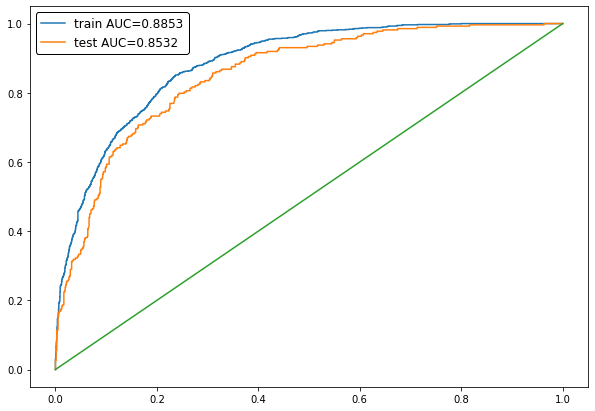

In [34]:
train_auc = roc_auc_score(y_train_eval, y_train_predicted)
test_auc = roc_auc_score(y_test_eval, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_eval, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test_eval, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

I use the CatBoost model for test sample prediction. Before that model should be trained on the whole train sample. 

In [39]:
boosting_model = CatBoostClassifier(n_estimators=200, 
                                             cat_features=cat_cols)
boosting_model.fit(train_data.drop(columns = ['Churn']), train_data.Churn)
cat_predict = boosting_model.predict_proba(test_data)[:, 1]

Learning rate set to 0.091733
0:	learn: 0.6362397	total: 14.3ms	remaining: 2.84s
1:	learn: 0.5887110	total: 27.8ms	remaining: 2.75s
2:	learn: 0.5548116	total: 40.9ms	remaining: 2.69s
3:	learn: 0.5271120	total: 53.4ms	remaining: 2.62s
4:	learn: 0.5055862	total: 68ms	remaining: 2.65s
5:	learn: 0.4882686	total: 80.7ms	remaining: 2.61s
6:	learn: 0.4750674	total: 94.9ms	remaining: 2.62s
7:	learn: 0.4630890	total: 109ms	remaining: 2.62s
8:	learn: 0.4533584	total: 123ms	remaining: 2.6s
9:	learn: 0.4453620	total: 137ms	remaining: 2.6s
10:	learn: 0.4398661	total: 149ms	remaining: 2.56s
11:	learn: 0.4343855	total: 162ms	remaining: 2.54s
12:	learn: 0.4302567	total: 174ms	remaining: 2.5s
13:	learn: 0.4282912	total: 183ms	remaining: 2.43s
14:	learn: 0.4245120	total: 195ms	remaining: 2.41s
15:	learn: 0.4206234	total: 210ms	remaining: 2.41s
16:	learn: 0.4181664	total: 225ms	remaining: 2.42s
17:	learn: 0.4162150	total: 239ms	remaining: 2.41s
18:	learn: 0.4138599	total: 252ms	remaining: 2.4s
19:	learn:

In [40]:
#clf_knn = ilpl.Pipeline(
#    steps=[('preprocessor', preprocessor), ('pca', PCA(n_components = 4)), ('classifier', KNeighborsClassifier(leaf_size = 15, n_neighbors = 34))]
#)
#clf_knn.fit(train_data.drop(columns = ['Churn']), train_data.Churn)
#final_pred = clf_knn.predict_proba(test_data)[:, 1]

In [41]:
#clf_ada = ilpl.Pipeline(
#    steps=[('preprocessor', preprocessor), ('pca', PCA(n_components = 4)), ('classifier', AdaBoostClassifier(random_state = 1, n_estimators = 59))]
#)
#clf_ada.fit(train_data.drop(columns = ['Churn']), train_data.Churn)
#final_pred = clf_ada.predict_proba(test_data)[:, 1]

Finally, I create a csv-table with indexes and prediction and download it

In [42]:
to_csv=pd.concat([pd.Series(np.arange(0, len(test_data))), pd.Series(cat_predict)], axis=1)

In [43]:
to_csv = to_csv.rename(columns = {0: 'Id', 1: 'Churn'})
to_csv.head()

,Id,Churn
0,0,0.038096
1,1,0.707953
2,2,0.690652
3,3,0.010563
4,4,0.002381


In [44]:
to_csv.to_csv('Churn_competition.csv',index=False)